In [1]:
from jupyterthemes import jtplot

# Analysis of StackOverflow Survey. Part 3

We build a model to predict job satisfaction for data coders. The notebook's contents are given below:


- Outline of CRISP-DM methodology implementation.
- Gather and prepare the data.
- Remove unnecessary data.
- Pre-process data from several columns.
- Sample data.
- Impute the missing values.
- Encode the predictors according to dtype.
- Evaluate several algorithms.
- Tune the best algorithm.
- Draw model insights.

## Import packages and libraries

In [2]:
# general packages and libraries
import os
import sys
import importlib

# data manipulation packages
import numpy as np
import pandas as pd

In [3]:
# data visualizations packages
import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

In [4]:
# numerical, statistical and machine learning packages and libraries
import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.base import (
    BaseEstimator, 
    TransformerMixin,
)
from sklearn.pipeline import (
    make_pipeline,
    Pipeline,
    FeatureUnion,
)
from sklearn.feature_selection import (
    SelectKBest, 
    mutual_info_classif,
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer,
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    StandardScaler,
    MultiLabelBinarizer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    RandomizedSearchCV
)

from sklearn.linear_model import (
    SGDClassifier,
    LogisticRegression,
) 

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
    
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    auc,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score
)

In [5]:
# create a string for the working directory
mypath = '/home/silvia/Documents/udacityND/ml_dsnd/proj1_dsnd/'

# add src folder to sys.path to use the local modules
sys.path.insert(1, mypath + 'src')

In [6]:
# import local modules 
import utils_functions as uf 
import utils_classes as uc
import local_maps as lm                                                                 

In [7]:
# re-load the modules as needed
importlib.reload(uf);
importlib.reload(uc);
importlib.reload(lm);

## Outline of CRISP-DM methodology implementation 

**Business Understanding**

The goal of this analysis is to predict the job satisfaction of a developer who works with data and to determine which factors influence it the most. This type of information is relevant to incoming developers who want to get more insight into the trends of the professional community. It also helps recruiters to identify and better understand the continuously changing demands of the industry. And it also provides valuable insight to employers in need of hiring and retaining data professionals.

**Data Understanding**

The well known collaboration platform Stack Overflow has been conducted annual surveys for a decade now. These are the largest and the most comprehensive surveys of developers ever conducted. The anonymized results of the surveys are publicly available for analysis at [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey).The data used in this analysis is based on the survey conducted in February 2020, just before the pandemic affected the entire world. An excerpt from the official analysis of the 2020 survey:

"*This year, we focused on seeking diverse representation while asking for information ranging from technologies and behavior to questions that will help us improve the Stack Overflow community for everybody who codes.*"

The 2020 survey has almost 65k responses from 184 countries and regions, and consists of 60 questions distributed over six sections:

- Basic Information 
- Education, Work, and Career
- Technology and Tech Culture
- Stack Overflow Usage + Community
- Demographic Information 
- Survey Opinions and Final Questions 

Steps taken towards a better understanding of the data:

- Preliminary report, using profiling Python package, see (`data_report.html`).
- Univariate and bivariate EDA for the features of interest (see `stackBlogDataAnalysis.ipynb`).
- Determine the number of features, and their data types.
- Find the unique values, classes each feature can take.
- Investigate the completeness of the data, find the counts of missing values for each feature.

**Data Preparation**

The model is focused on data developers, such as data scientist or machine learning specialist, data or business analyst and data engineer, these are referred as data_coders to distinguish them from the rest of the developers, referred as other_coders for short. The data is pre-processed and processed in several stages.

1. Preliminary preprocessing: 
    - rename several columns, 
    - change strings to shorter expressions, 
    - create column DevClass to distinguish between data_coders and other_coders.  


2. Preprocess data:
    - remove unnecessary data: 
        - features not relevant for the analysis (manually picked),
        - developers who are not employed, 
        - other_coders (do not work with data).
    - drop missing values in `JobSat`column,
    - encode numerically `JobSat` column,
    - parse columns with multi strings entries
    - update dtypes.


3. Sample data (70% train set, 30% test set).


4. Feature engineering and imputation of missing values.
    - continuous features: 
        - impute missing values with  KNNImputer with K=5,
        - scale values using SimpleScaler.
    - discrete features with multi strings entries:
        - split the sets of strings into binary columns with MultiLabelBinarizer,
        - for each feature, drop all but three of most populous columns obtained from expansion.
    - discrete features with a few levels:
        - impute the missing values by filling with string 'missing', 
        - encode via OrdinalEncoder.

*Note*:   
- Automated feature selection was performed in parallel, and the performance of the model did not improve significantly over the manual selection of columns.  
- Feature engineering and imputation of missing values are performed separately on the train set and on the test set, the transformers are fitted on the train set and applied to both train set and test set. 

**Modeling**

The objective of the project is to built a multi-label classifier. In order to find the best algorithm in this case:

- use KNeighborsClassifier with default hyperparameters as a baseline model.

- Use KFold cross validation to train and evaluate several classifiers (non-ensemble and ensemble algorithms).

The tree based algorithms have the best cross validation scores. Among these, the best score is attained by the RandomForestClassifier.

- Do a RandomizedSearchCV through an extensive set of hyperparameters to determine the best combination for the RandomForestClassifier.


- Apply the trained best classifier on the test set and record the predictions vector.


**Evaluation**

We print out the confusion matrix and calculate accuracy, precision, recall and F1-score, mostly using the macro method of averaging over the individual labels scores. 

1. For the baseline model we obtain accuracy of 0.579 on the train set and an accuracy of 0.369 on the test set. The precision, recall and F1 scores have similar values. All these are acceptable in this case.

2. To choose between various algorithms, we use cross validation with k=5 folds on the train set, and evaluate the cross validation accuracy. The best performing model is RandomForestClassifier with a score of 0.587.

3. After randomized search through a set of hyperparameters, the best model is:
>RandomForestClassifier(max_depth=90, min_samples_split=5, n_estimators=1400)

The accuracy, precision and recall have almost perfect scores on the train set. On the test set the accuracy is 0.626 (an increase of 0.047 from the untuned classifier). The best score on the test set is precision 0.738. The F1 score is 0.586. These values are averaged over the 5 classification labels.

Among the 5 labels in this classification, the labels 1(very dissatisfied) and 3(neutral) have 0.9 precision. This indicates a bias of the classifier towards more negative answers. This is an interesting issue for further investigation. 

These values indicate that the classifier has a good ability to identify the relevant data points. We also have to keep in mind that:

- there are lots of missing values in the columns of interest, our imputation methods affect the performance of the model,
- we kept two columns that originate in multiple choice, multiple answers questions, these columns generate in feature engineering 10-20 new columns each, we avoid overfitting by dropping many of these interim features,

We conclude that the metrics obtained in this case are satisfactory for the purpose of this project.

The results are interpreted using various methods:

- visualize a sample decision tree;
- evaluate the feature importance using the corresponding method of the classifier;
- find the permutation feature importance;
- use SHAP to compute feature importance and explain individual predictions.

The SHAP computations can be quite lengthy, thus we performed the evaluation on a 500 points sample of he test set. We learn that the features that influence the job satisfaction the most are JobSeek, OnboardGood, ConvComp (using SHAP or permutation importance), and ConvComp, YearsCode, WorkWeekHrs using the feature importance method for the classifier.

**Deployment**

The project does not deploy the model for production. Instead we created a module `model.py` which contains a refactored version of most of the above steps, using pipe and pipelines as well as calls to local modules. It uploads the raw data and prints out the performance metrics of the model.

## Predict Job Satisfaction for 2020 StackOverflow Developers Survey

We separate the respondents of the 2020 StackOverflow Developer Survey into data coders (data scientist or machine learning specialist, data or business analyst, data engineer) and other coders. In what follows we restrict the dataset to the data coders and address the following questions:

>_What can we tell about the job satisfaction of a data developer?_  
>_What factors do influence the job satisfaction?_

We build a predictive model for the job satisfaction for data developers. This is a multi-class classification question, where the satisfaction levels are: 

> very dissatisfied - 1  
> slightly dissatisfied - 2  
> neither satisfied nor dissatisfied - 3   
> slightly satisfied - 4  
> very satisfied - 5.

## Load the data

Upload the data and keep the subset that contains those developers that work in data science related fields.

In [8]:
# upload the datafile as pandas dataframe
df = pd.read_csv(mypath+'data/interim/survey20_updated.csv', index_col=[0])
# check for success
df.shape

(64461, 61)

## Remove unnecessary data

In [9]:
# create a copy of the data
df1 = df.copy()

### Retain only the developers that work with data 

In [10]:
# parse each list of strings entry 
df1['DevType'] = df1['DevType'].str.split(';')

# transform each element of a list-like to a row, replicating index values
df1 = df1.explode('DevType')

# check the outcome
df1.shape

(172185, 61)

In [11]:
# retain only those rows that contain data coders
df1 = df1.loc[df1.DevType.str.contains('Data ', na=False)]
df1.shape

(11750, 61)

### Retain the developers that are employed

In [12]:
# check the employment types for data coders
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Not employed, but looking for work                       564
Employed part-time                                       469
Name: Employment, dtype: int64

In [13]:
# retain only the employed data developers
df1 = df1[df1['Employment'] != 'Not employed, but looking for work']

# check for success
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Employed part-time                                       469
Name: Employment, dtype: int64

### Retain only the respondents that code professionally

In [14]:
# check the professional status of the employed developers
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
I am a student who is learning to code                                            296
I used to be a developer by profession, but no longer am                          203
I code primarily as a hobby                                                       163
Name: MainBranch, dtype: int64

In [15]:
# create a list of main branch choices
main_choices = df1.MainBranch.value_counts().index.to_list()

# retain only those rows where MainBranch contains data professionals
df1 = df1[df1.MainBranch.isin(main_choices[:2])]

# check the outcome
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
Name: MainBranch, dtype: int64

### Drop the rows with missing values in JobSat column

In [16]:
# drop rows with missing JobSat
df1.dropna(subset=['JobSat'], inplace=True)

### Remove irrelevant columns

In [17]:
# drop all the columns in the list
df1.drop(columns=lm.cols_del, inplace=True)

# check the output
df1.shape

(10372, 18)

## On feature selection

Since we are left with less than 20 features, I will not perform additional feature selection. After experimenting with a couple of feature selection options, such as `mutual_info_classif` and `SelectKBest`, I observed that working with the suggested 10-15 features did not significantly improved the performance of the model.

## Preprocess data

### Numerically encode JobSat column

In [18]:
# encoding map for job satisfaction
JobSat_dict =  {'Very dissatisfied': 1, 'Slightly dissatisfied': 2,
               'Neither satisfied nor dissatisfied': 3, 
               'Slightly satisfied': 4, 'Very satisfied': 5}

In [19]:
# use the custom labelling 
df1['JobSat'] = df1['JobSat'].map(JobSat_dict)
# check the outcome
df1['JobSat'].value_counts()

5    3582
4    3079
2    1623
3    1242
1     846
Name: JobSat, dtype: int64

### Update YearsCode column entries and dtype

In [20]:
# replace strings with numerical entries
replace_dict = {'Less than 1 year': '0', 'More than 50 years': '51'}
df1.replace(replace_dict, inplace=True)

# change dtype to numeric
df1['YearsCode'] = pd.to_numeric(df1['YearsCode'])

### Pre-process the multi levels columns

In [21]:
# the list of columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

In [22]:
# the list of columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

# apply the transformation to the two columns
df1 = uf.parse_multi_columns(df1, multi_cols)

## Save the preprocessed data to file

In [23]:
# save a copy of the preprocessed dataframe
df1.to_csv(mypath + 'data/interim/survey20_pprocessed.csv')

## Refactor code

Rewrite all of the steps for data pre-processing in a single function.

In [24]:
# create a fresh copy of the dataset
dft = df.copy()

# all data cleaning and preprocessing steps
dft = uf.remove_clean_data(dft)

# save the data to a file - refactored version
dft.to_csv(mypath + 'data/interim/survey20_pproces_refactor.csv')

### Group columns by data types

In [25]:
# the list of numerical columns
num_cols = df1.select_dtypes(include='float64').columns.to_list()
print(num_cols)

['ConvertedComp', 'WorkWeekHrs', 'YearsCode']


In [26]:
# the list of discrete columns with many levels 
multi_cols = ['PlatformWorkedWith', 'CollabToolsWorkedWith']

In [27]:
# the list of discrete columns with several levels
cat_cols = df1.select_dtypes(include='object').columns.to_list()
uni_cols = list(set(cat_cols) - set(multi_cols))
print(uni_cols)

['Overtime', 'EdLevel', 'DevOps', 'OrgSize', 'OnboardGood', 'JobSeek', 'UndergradMajor', 'PurchaseWhat', 'EdImpt', 'Learn', 'OpSys', 'DevOpsImpt']


## Sample data, create features and target datasets

Create a dataframe X of features and a pandas series y that contains the labels.

In [28]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

In [29]:
# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
X.shape, len(y)

((10372, 17), 10372)

### Isolate a test set

In [30]:
# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (7260, 17) (7260,)
Test (3112, 17) (3112,)


### Create a profiling report for the train set

In [31]:
# run this once to generate the report and save it as html file

import pandas_profiling
profile = pandas_profiling.ProfileReport(X_train, minimal=False)

save_path = mypath + 'reports/'
filename = 'data_report_train.html'
filename = os.path.join(save_path, filename)
profile.to_file(output_file = filename)

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Encode and impute the predicting variables

### Encode the columns with many levels

There are several options to choose from when encoded the columns with high cardinality, that originate from multiple answers questions. If we use MultiLabelBinarizer, a column such PlatformWorkedWith will create 16 new columns, which doubles the number of features in the dataframe. In order to address this column explosion, we droped all the new columns but the 3 that correspond to the most popular choices. 

After data cleaning and pre-processing the columns with many levels are grouped n the list: multi_cols. The steps are:
- use the MultiLabelBinarizer to create boolean columns for each possible answer found in the pre-processed entries,
- keep the columns that correspond to the most populous choices for each of he initial columns that are encoded.

In [32]:
# create an instance of the encoder
mlb = MultiLabelBinarizer()

In [33]:
# fit the binarizer on the train set
mlb_plat = mlb.fit(X_train['PlatformWorkedWith'])

# transform the corresponding column in the train set
mlb_plat_train =  mlb_plat.transform(X_train['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_train = pd.DataFrame(mlb_plat_train, columns = mlb_plat.classes_,
                              index = X_train.index)

# list the three most popular platforms to retain
platform_keep = list(temp_plat_train.sum().sort_values(ascending=False).head(3).index)

# combine the two dataframes and drop the initial column
X_train = pd.concat([X_train, temp_plat_train[platform_keep]],
                    axis=1).drop(columns = ['PlatformWorkedWith'])

# apply the same transformations to the test set
mlb_plat_test =  mlb_plat.transform(X_test['PlatformWorkedWith'])

# put the outcome in pandas dataframe form
temp_plat_test = pd.DataFrame(mlb_plat_test, columns = mlb_plat.classes_,
                             index = X_test.index)

# combine the two dataframes and drop the initial column
X_test = pd.concat([X_test, temp_plat_test[platform_keep]], 
                   axis=1).drop(columns = ['PlatformWorkedWith'])

In [34]:
# check the outcome
print(platform_keep)
print('')
print(X_train.shape, X_test.shape)

['Linux', 'Windows', 'Docker']

(7260, 19) (3112, 19)


In [35]:
# create an instance of the encoder
mlb = MultiLabelBinarizer()

In [36]:
# fit the binarizer on the train set
mlb_colab = mlb.fit(X_train['CollabToolsWorkedWith'])

# transform the corresponding column in the train set
mlb_colab_train =  mlb_colab.transform(X_train['CollabToolsWorkedWith'])

# put the outcome in pandas dataframe form
temp_colab_train = pd.DataFrame(mlb_colab_train, columns = mlb_colab.classes_,
                         index = X_train.index)

# list the three most popular platforms to retain
colab_keep = list(temp_colab_train.sum().sort_values(ascending=False).head(3).index)

# combine the two dataframes and drop the initial column
X_train = pd.concat([X_train, temp_colab_train[colab_keep]],
                    axis=1).drop(columns = ['CollabToolsWorkedWith'])

# apply the same transformations to the test set
mlb_colab_test =  mlb_colab.transform(X_test['CollabToolsWorkedWith'])

# put the outcome in pandas dataframe form
temp_colab_test = pd.DataFrame(mlb_colab_test, columns = mlb_colab.classes_,
                              index = X_test.index)

# combine the two dataframes and drop the initial column
X_test = pd.concat([X_test, temp_colab_test[colab_keep]], 
                   axis=1).drop(columns = ['CollabToolsWorkedWith'])

In [37]:
# check the outcome
print(colab_keep)
print('')
print(X_train.shape, X_test.shape)

['Github', 'Slack', 'Jira']

(7260, 21) (3112, 21)


In [38]:
# create a list with all columns created after the above steps
all_keep = platform_keep + colab_keep
all_keep

['Linux', 'Windows', 'Docker', 'Github', 'Slack', 'Jira']

#### Comment:

All the above steps will be included in a custom transformer for the processing pipeline.

### Impute the numerical columns

We use a KNN imputer with n=5 to impute the missing values in the continuous features. To avoid data leakage, the imputer is trained on the training set and then applied to the training set and to the test set.  

In [39]:
# select the numerical columns in the train dataset
X_train_num = X_train[num_cols]

# create an instance of the KNN imputer
num_imputer = KNNImputer(n_neighbors=5)

# fit_transform the imputer on the training set
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), 
                               columns = X_train_num.columns,
                               index = X_train_num.index)

# select the numerical columns in the test set
X_test_num = X_test[num_cols]
# transform the test set with the imputer that was fit on the training set
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test_num),
                              columns=X_test_num.columns,
                              index=X_test_num.index)

### Scale the continuous variables

In [40]:
# create an instance of the scaler
scaler = StandardScaler()

# scale the numerical variables, fit and transform on the training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imp), 
                                columns = X_train_num_imp.columns, 
                                index = X_train_num_imp.index)

# use the scaler fit on training set to transform the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num_imp), 
                             columns = X_test_num_imp.columns,
                            index = X_test_num_imp.index)   

### Impute the remaining discrete features

We impute the missing values in the remaining discrete columns using a simple imputer by filling with the string 'missing'. This will allow to be able to identify the missing values after processing, if necessary.

In [41]:
# select the remaining discrete columns in the training set
X_train_uni = X_train[uni_cols]

# create an instance of the simple imputer
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# fit and transform on the training data
X_train_uni_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_uni), 
                               columns = X_train_uni.columns,
                              index = X_train_uni.index)

# select the categorical columns in the test set
X_test_uni = X_test[uni_cols]

# transform the test data with the imputer fit on the training set
X_test_uni_imp = pd.DataFrame(cat_imputer.transform(X_test_uni),
                            columns = X_test_uni.columns,
                             index = X_test_uni.index)

### Encode the low level predictors

In [42]:
# encode the low cardinality discrete columns
def ord_encode_predictors(X_train, X_test):
    """
    Encodes the discrete features of the predictors.
    Create an instance of the OrdinalEncoder.
    Fit the encoder on the train set, transform the train and the test sets.
    INPUT: 
        X_train, X_test = train and test dataframes
    OUTPUT:
        X_train_trans, X_test_trans = encoded train and test dataframes
    """
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(oe.transform(X_train), 
                               columns = X_train.columns,
                               index = X_train.index)
    X_test_enc = pd.DataFrame(oe.transform(X_test), 
                              columns = X_test.columns,
                             index = X_test.index)
    return X_train_enc, X_test_enc

In [43]:
# the low cardinality encoded discrete features
X_train_uni_enc, X_test_uni_enc = ord_encode_predictors(X_train_uni_imp[uni_cols],
                                                        X_test_uni_imp[uni_cols])

## Recombine the data

In [44]:
# combine the  X_train frames 
X_train_cat = pd.concat([X_train[all_keep], X_train_uni_enc], axis=1)
X_train_prep = pd.concat([X_train_cat, X_train_scaled], axis=1)

# combine the X_test frames 
X_test_cat = pd.concat([X_test[all_keep], X_test_uni_enc], axis=1)
X_test_prep = pd.concat([X_test_cat, X_test_scaled], axis=1)

In [45]:
# save the data sets to files
X_train_prep.to_csv(mypath + 'data/processed/x_train_data.csv')
X_test_prep.to_csv(mypath + 'data/processed/x_test_data.csv')

## Refactor the code: build processing data pipeline

In [46]:
## refactor code: processing data

# the steps in the categorical pipeline for columns of low cardinality
uni_cat_pipeline = Pipeline( steps = [( 'unicat_selector', uc.FeatureSelector(uni_cols) ),
                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                  ( 'ordinal_encoder', OrdinalEncoder() ) ] )

# the steps in the categorical pipeline for columns of high cardinality
multi_cat_pipeline = Pipeline( steps = [( 'multicat_selector', uc.FeatureSelector(multi_cols) ),
                                  ( 'multi_encoder', uc.MultiColumnsEncoder(multi_cols) ) ] )

# the steps in the numerical pipeline     
num_pipeline = Pipeline( steps = [ ('num_selector', uc.FeatureSelector(num_cols) ),
                                  ('imputer', KNNImputer(n_neighbors=5) ),
                                  ( 'std_scaler', StandardScaler() ) ] )

# combine the numerical and the categorical pipelines
full_pipeline = FeatureUnion( transformer_list = [ ( 'unicat_pipeline', uni_cat_pipeline ), 
                                                  ( 'multicat_pipeline', multi_cat_pipeline ) ,
                                                 ( 'numerical_pipeline', num_pipeline )] )

## Baseline model

In [47]:
# create an instance of the classifier, using default parameters
kneigh = KNeighborsClassifier()

# fit the classifier on the train set
KN_clf = kneigh.fit(X_train_prep, y_train)

# predict on the test set
y_pred_kn = KN_clf.predict(X_test_prep) 

In [48]:
# evaluate performance metrics on the train set
perf_train_kn = pd.Series(uf.get_perf_metrics(KN_clf, X_train_prep, y_train), 
                       index = lm.metrics_list)

# evaluate performance metrics on the test set
perf_test_kn = pd.Series(uf.get_perf_metrics(KN_clf, X_test_prep, y_test), 
                         index = lm.metrics_list)

# combine performance metrics for the baseline model
perf_model_kn = pd.DataFrame.from_dict({'train': perf_train_kn,
                                        'test': perf_test_kn}).round(3)

In [49]:
# print evaluation metrics and results

print('Performance metrics comparison for KNeighbors:\n', perf_model_kn)

result1_kn = confusion_matrix(y_test, y_pred_kn)
print('\nKNeighbors Confusion Matrix for Test Set:')
print(result1_kn)

result2_kn = classification_report(y_test, y_pred_kn)
print('\nKNeighbors Classification Report for Test Set:')
print (result2_kn)

Performance metrics comparison for KNeighbors:
            train   test
accuracy   0.579  0.369
precision  0.557  0.319
recall     0.539  0.314
f1         0.546  0.315

KNeighbors Confusion Matrix for Test Set:
[[ 57  27  20  77  77]
 [ 37 155  40 132 122]
 [ 19  73  55 116 120]
 [ 46 147  88 390 250]
 [ 55 141  74 303 491]]

KNeighbors Classification Report for Test Set:
              precision    recall  f1-score   support

           1       0.27      0.22      0.24       258
           2       0.29      0.32      0.30       486
           3       0.20      0.14      0.17       383
           4       0.38      0.42      0.40       921
           5       0.46      0.46      0.46      1064

    accuracy                           0.37      3112
   macro avg       0.32      0.31      0.31      3112
weighted avg       0.36      0.37      0.36      3112



## Evaluate several algorithms

In [50]:
# source: https://www.kaggle.com/richarde/easy-pipeline-and-model-selection

# use KFold cross validation to train and evaluate several models and choose the 
# most performant model

num_folds = 5
scoring = 'accuracy'
models = []

# non-ensemble algorithms
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier()))

# ensemble methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)

LDA 0.398347 0.016561 
KNN 0.357025 0.005982 
CART 0.518871 0.014639 
NB 0.392011 0.012461 
SVM 0.405923 0.008586 
XGB 0.462121 0.015214 
AB 0.430028 0.010532 
GBM 0.471763 0.011333 
RF 0.588292 0.007785 
ET 0.583609 0.008783 


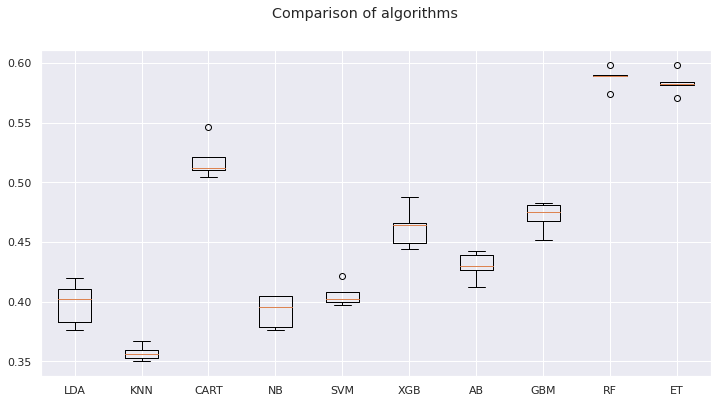

In [51]:
# compare algorithms boxplot
fig = plt.figure(figsize = [12,6])
fig.suptitle('Comparison of algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

#### Comments: 
The ensemble tree based algorithms RandomForest and ExtraTrees classifiers perform the best. Since RandomForest has slightly better baseline accuracy, we will tune its parameters.

## Tune the best algorithm

Using RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [51]:
# create the random parameter grid to sample from during fitting
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], # no trees
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max no of levels in each tree
              'min_samples_leaf': [1, 2, 4], # min no of data points allowed in leaf node
               'min_samples_split': [2, 5, 10], # min no of data points placed in a node before split
               'max_features': ['auto', 'sqrt'] # max no of features considered for a splitting node
             }   

# create an instance of the classifier
model_RF = RandomForestClassifier(random_state = 42)

# random search of parameters using 5-fold cross validation
# search across 100 different combinations
# set n_jobs = 1 to use only one processor at a time, to avoid memory leaks
RF_grid = RandomizedSearchCV(estimator = model_RF, 
                         param_distributions = random_grid,
                         n_iter = 100, cv = 5, verbose = 2, 
                         random_state = 42, n_jobs = 1)
                        
# fit the random search model
RF_random = RF_grid.fit(X_train_prep, y_train)

# print the best score and the best parameters
print("Best: %f using %s" % (RF_random.best_score_, RF_random.best_params_))

means_RF = RF_random.cv_results_['mean_test_score']
stds_RF = RF_random.cv_results_['std_test_score']
params_RF = RF_random.cv_results_['params']

for mean_RF, stdev_RF, param_RF in zip(means_RF, stds_RF, params_RF):
    print("%f (%f) with: %r" % (mean_RF, stdev_RF, param_RF))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   7.8s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   7.8s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   7.8s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   8.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   7.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   5.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=   5.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_es

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   7.1s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.5s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   4.4s
[CV] END max_depth=90, max_

[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.2s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.0s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.1s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.1s
[CV] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1600; total time=   7.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.1s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=  10.5s
[CV] END max_depth=40, max_featu

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   6.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=   6.6s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.2s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.2s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s
[CV] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   2.7s
[CV] END max_depth=110, max_fea

[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.9s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.9s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.9s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.0s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   9.7s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   9.7s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=60, max_features=

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   3.1s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   4.0s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=   4.0s
[CV] END max_depth=60, max_features=sqrt

[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=   7.7s
[CV] END max_depth=30, max_featu

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.4s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.3s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   5.3s
[CV] END max_depth=100, ma

In [52]:
# print the parameters of the best estimator
#best_RF = RF_grid.best_estimator_
#best_RF

In [53]:
# create an instance of the best model
RF_clf = RandomForestClassifier(n_estimators = 1400, 
                                min_samples_split = 5, 
                                min_samples_leaf = 1,
                                max_features = 'auto',
                                max_depth = 90,
                                random_state = 42)
# fit the classifier on the train set
RF_clf.fit(X_train_prep,y_train)
# predict on the test set
y_pred_RF = RF_clf.predict(X_test_prep)

# compute cv scores on the train set 
scores_train = cross_val_score(RF_clf, X_train_prep, y_train, cv=10)

print('Cross validation score for RandomForestClassifier on train set is:', scores_train.mean())

Cross validation score for RandomForestClassifier on train set is: 0.6117079889807162


In [54]:
# print the final model parameters
print('Final Model Parameters:\n')
RF_clf.get_params()

Final Model Parameters:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [55]:
# evaluate performance metrics on the train set
perf_train_RF = pd.Series(uf.get_perf_metrics(RF_clf.fit(X_train_prep,y_train),
                                              X_train_prep, y_train), 
                       index = lm.metrics_list)

# evaluate performance metrics on the test set
perf_test_RF = pd.Series(uf.get_perf_metrics(RF_clf.fit(X_train_prep,y_train),
                                             X_test_prep, y_test), 
                         index = lm.metrics_list)

# combine performance metrics for the baseline model
perf_model_RF = pd.DataFrame.from_dict({'train': perf_train_RF,
                                        'test': perf_test_RF}).round(3)

In [56]:
# print evaluation metrics and results

print('Performance metrics comparison for RandomForestClassifier:\n', perf_model_RF)

result1_RF = confusion_matrix(y_test, y_pred_RF)
print('\nRandomForestClassifier Confusion Matrix for Test Set:')
print(result1_RF)

result2_RF = classification_report(y_test, y_pred_RF)
print('\nRandomForestClassifier Classification Report for Test Set:')
print (result2_RF)

Performance metrics comparison for RandomForestClassifier:
            train   test
accuracy   0.996  0.624
precision  0.998  0.738
recall     0.992  0.538
f1         0.995  0.583

RandomForestClassifier Confusion Matrix for Test Set:
[[ 95  30   3  40  90]
 [  4 230   3 175  74]
 [  2  23 141 139  78]
 [  3  29   4 617 268]
 [  2  13   1 188 860]]

RandomForestClassifier Classification Report for Test Set:
              precision    recall  f1-score   support

           1       0.90      0.37      0.52       258
           2       0.71      0.47      0.57       486
           3       0.93      0.37      0.53       383
           4       0.53      0.67      0.59       921
           5       0.63      0.81      0.71      1064

    accuracy                           0.62      3112
   macro avg       0.74      0.54      0.58      3112
weighted avg       0.67      0.62      0.61      3112



## Interpret results

### Visualize decision trees

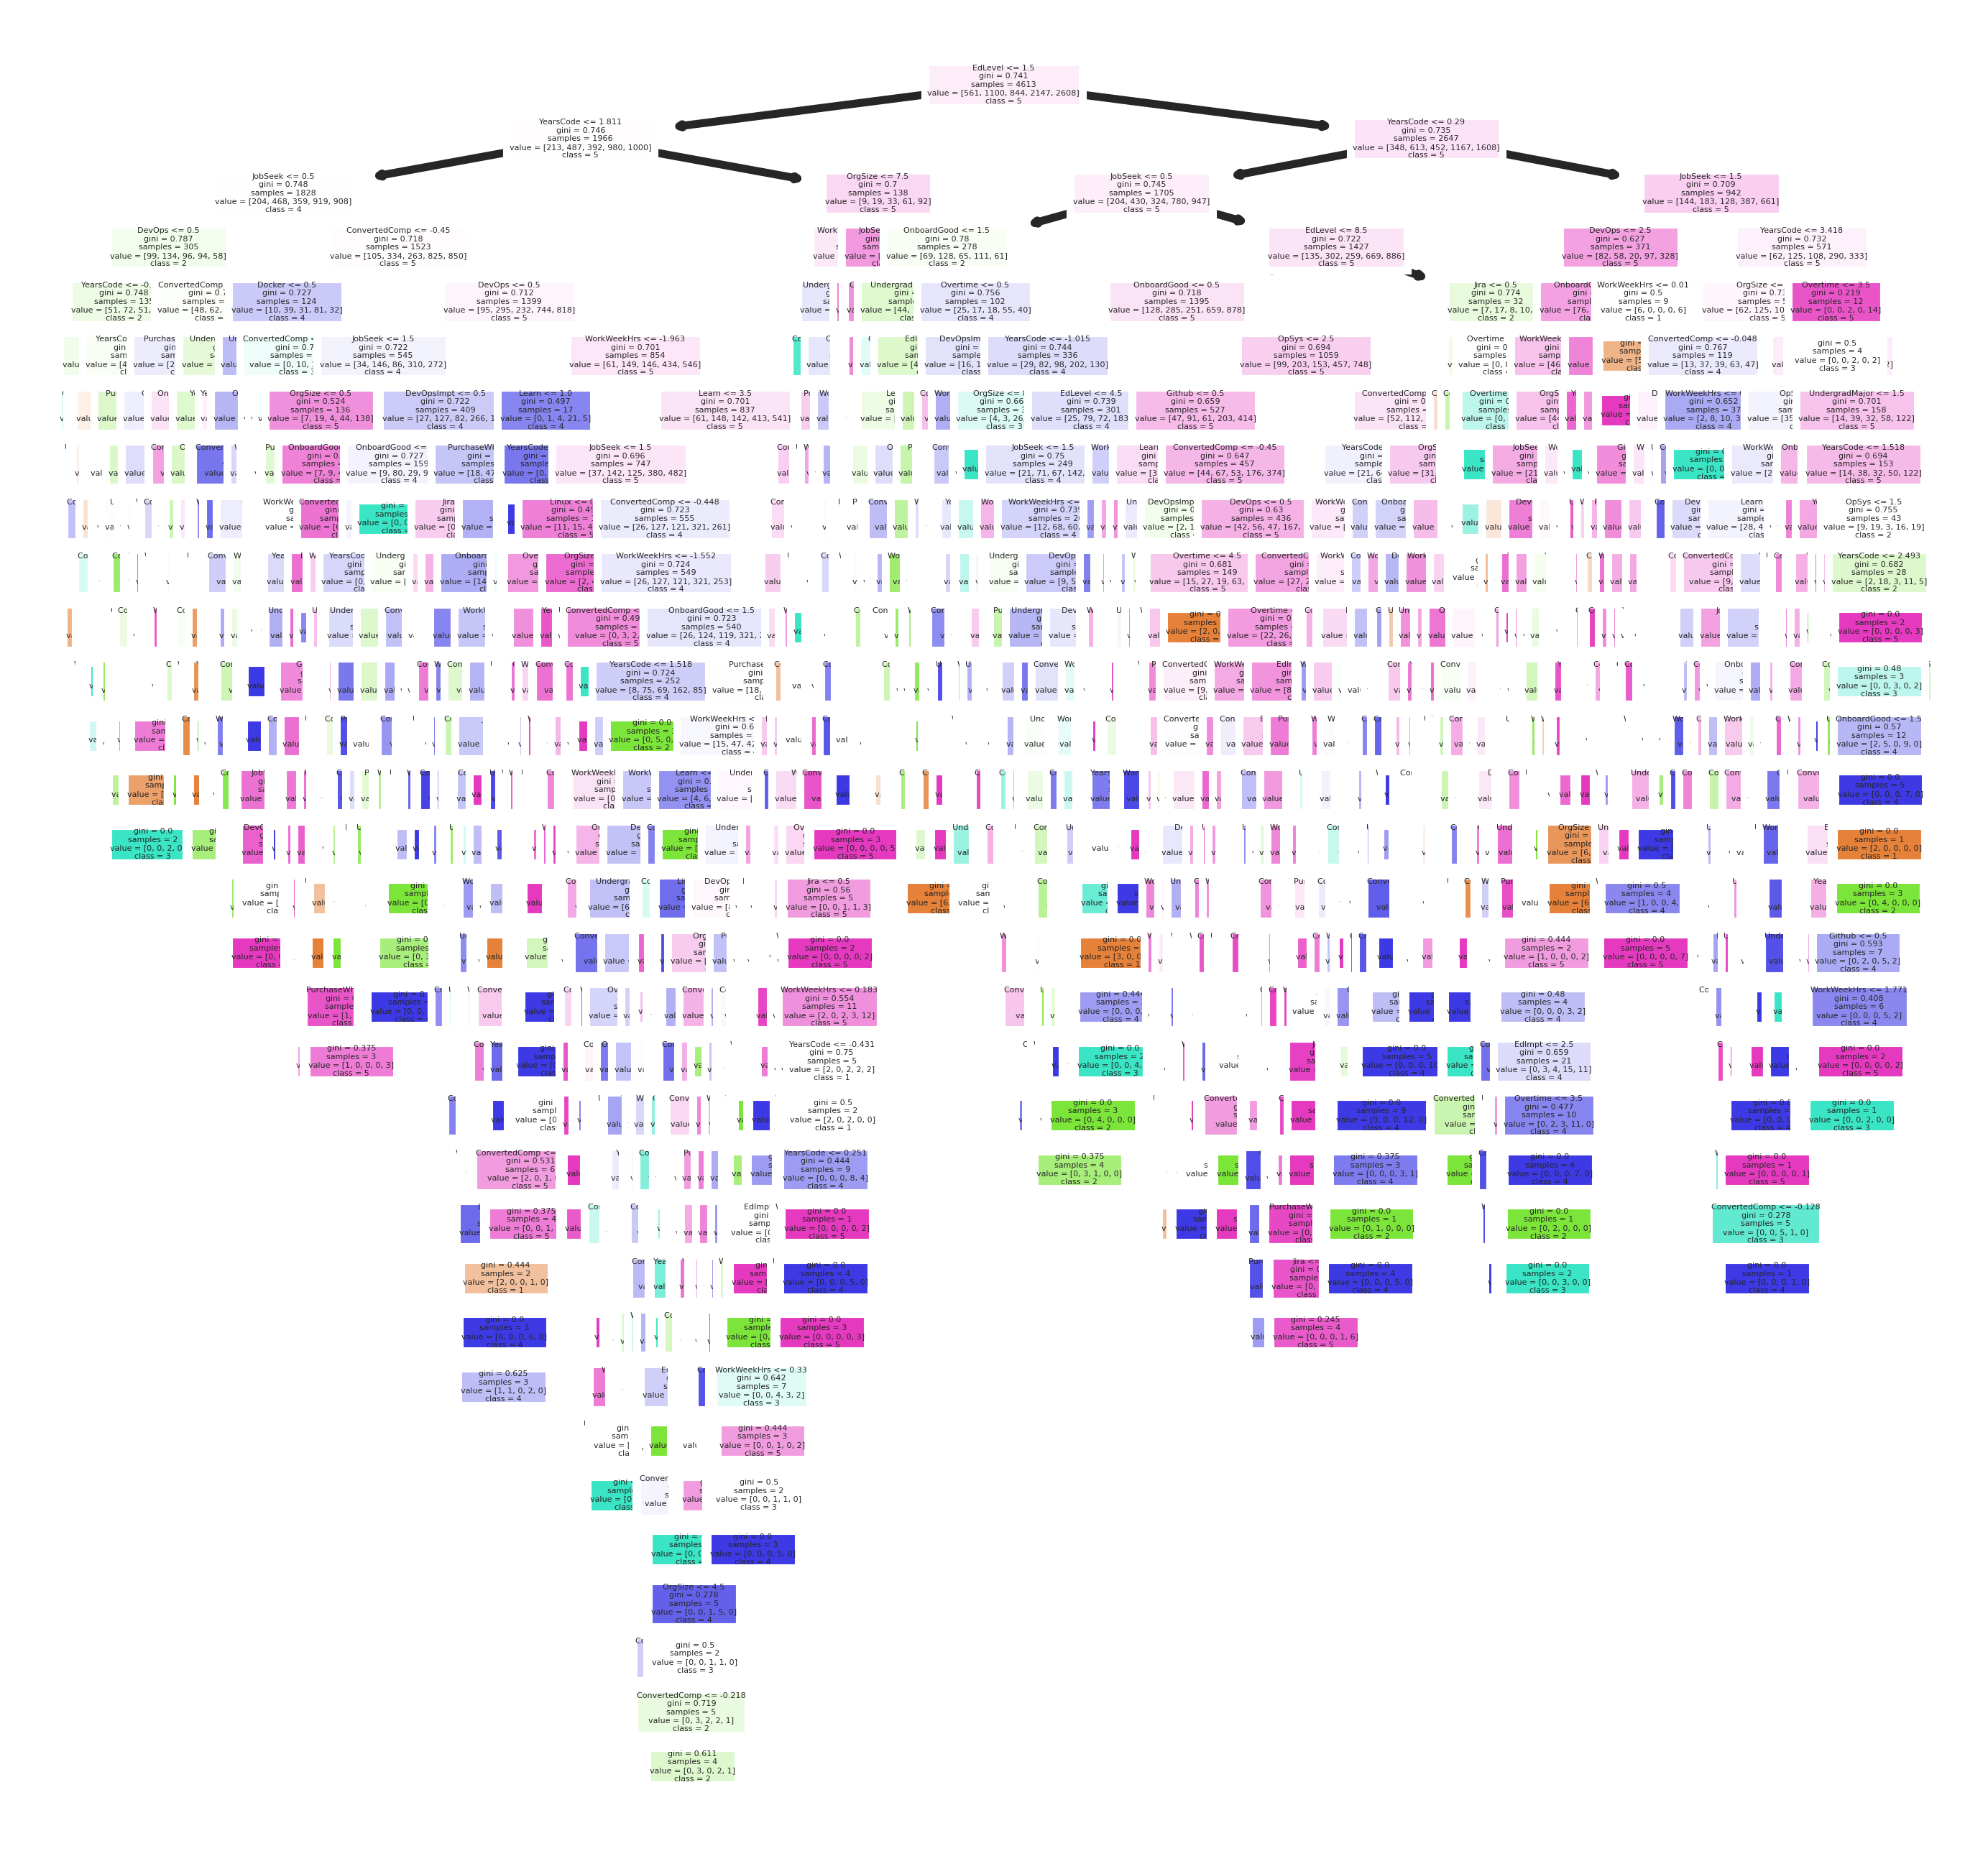

In [57]:
# visualize one of the decision trees and save image to a file
from sklearn import tree

fn = X_train_prep.columns
cn = ['1','2','3','4','5']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(RF_clf.estimators_[1],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(mypath + 'reports/images/visual_tree.png')

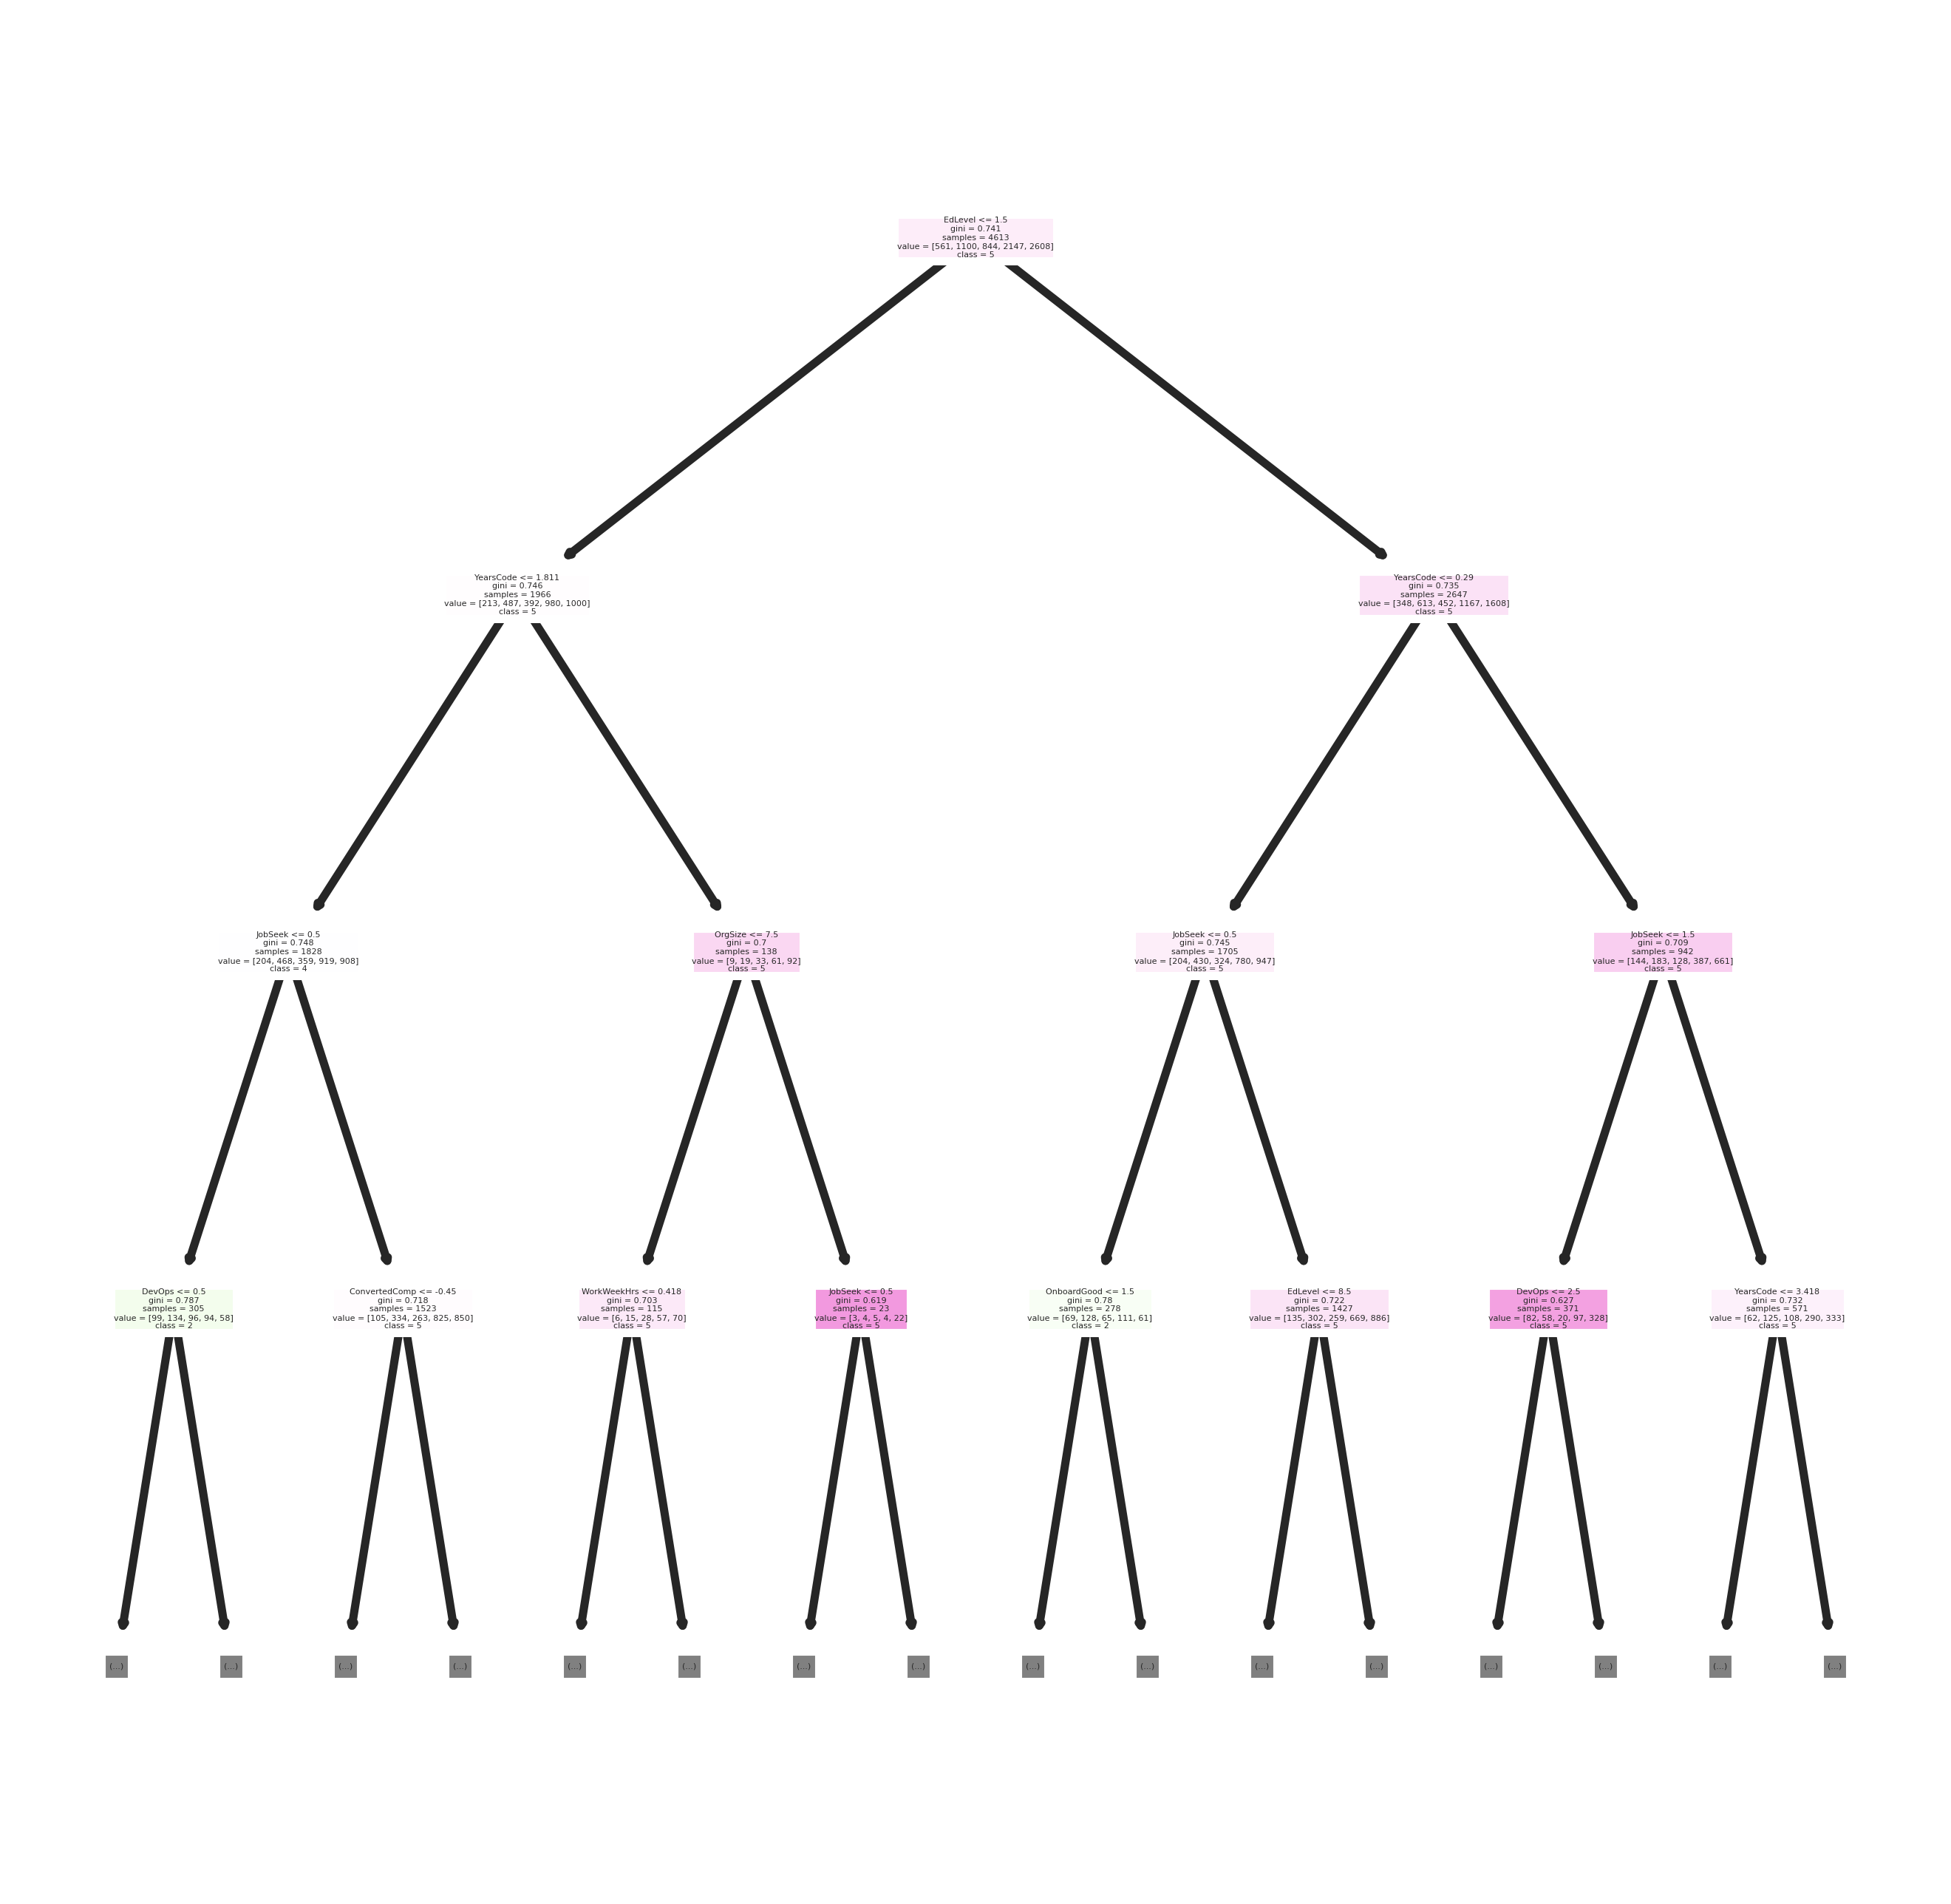

In [58]:
# visualize the tree up to depth 3
fn = X_train_prep.columns
cn = ['1','2','3','4','5']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(RF_clf.estimators_[1], max_depth = 3,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig(mypath + 'reports/images/visual_tree_reduced.png')

### Find feature importance

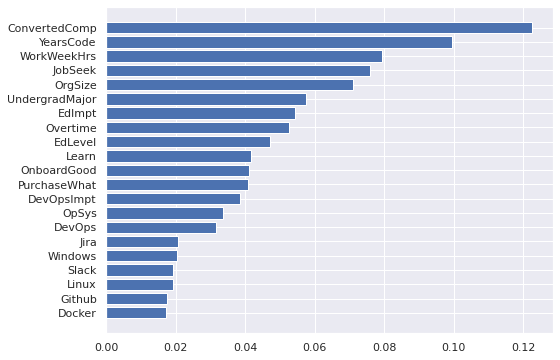

In [59]:
# compute feature importance - Gini importance and save them in a dataframe
feat_imp = pd.DataFrame({'feature': X_train_prep.columns,
                         'score': RF_clf.feature_importances_}).sort_values(by='score',
                                                                           ascending=True)
# plot feature importance 
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(feat_imp.feature, feat_imp.score);

### Find permutation based feature importance 

Text(0.5, 0, 'Permutation Importance')

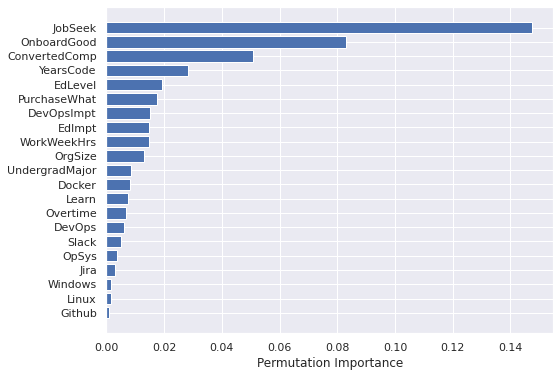

In [60]:
# permutation based feature importance
from sklearn.inspection import permutation_importance

# the permutation based importance
perm_importance = permutation_importance(RF_clf, X_test_prep, y_test)

# plot feature importance 
fig, ax = plt.subplots(figsize=(8, 6))

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test_prep.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Explain feature importance with SHAP

In [61]:
# import the package
import shap
# print the JS visualization code to the notebook
shap.initjs()

# create the explainer
explainer = shap.TreeExplainer(RF_clf)
shap_values = explainer.shap_values(X_test_prep.head(500))

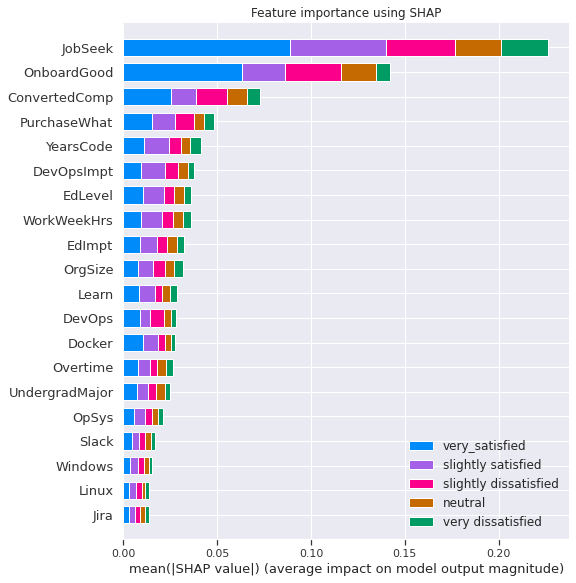

In [62]:
class_names=['very dissatisfied', 'slightly dissatisfied', 'neutral', 'slightly satisfied', 'very_satisfied']
               
# global feature importance from SHAP values
plt.title('Feature importance using SHAP')
shap.summary_plot(shap_values, X_test_prep, class_names = class_names, plot_type='bar', show=False)

plt.savefig(mypath + 'reports/images/shap_importance_reduced.png',
           bbox_inches='tight', pad_inches=0.3)


### The dependence plots for first 3 features

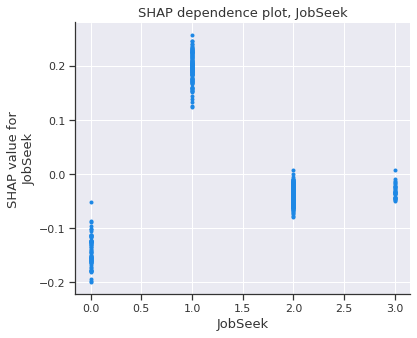

In [63]:
# partial dependence plot for JobSeek & very satissfied
shap.dependence_plot('JobSeek', shap_values[4], 
                     X_test_prep.head(500), interaction_index=None, 
                    title='SHAP dependence plot, JobSeek')

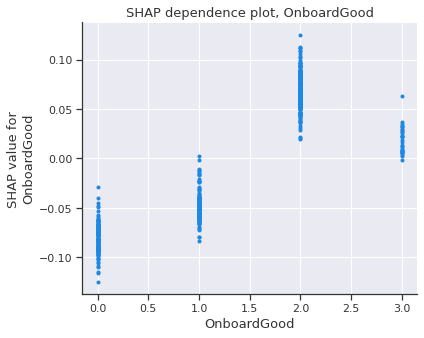

In [64]:
# partial dependence plot for OnboardGood & very satissfied
shap.dependence_plot('OnboardGood', shap_values[4], 
                     X_test_prep.head(500), interaction_index=None, 
                    title='SHAP dependence plot, OnboardGood')

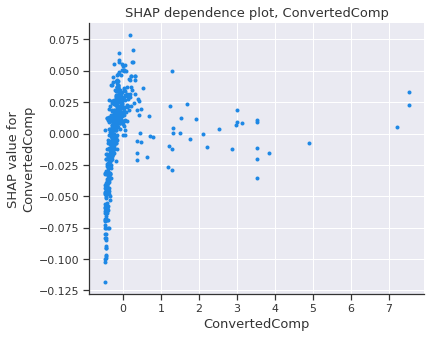

In [65]:
# partial dependence plot for OnboardGood & very satissfied
shap.dependence_plot('ConvertedComp', shap_values[4], 
                     X_test_prep.head(500), interaction_index=None, 
                    title='SHAP dependence plot, ConvertedComp')

### Explain individual predictions

In [66]:
# choose an instance from the test dataset
part_instance = X_test_prep.iloc[[10]]
part_instance.T.round(3).sort_values(by = 47858, ascending=False)

Respondent,47858
DevOpsImpt,4.000
OrgSize,3.000
EdImpt,3.000
Learn,3.000
OpSys,3.000
JobSeek,2.000
UndergradMajor,2.000
Github,1.000
Overtime,1.000
EdLevel,1.000


In [67]:
# calculate SHAP values
shap_values = explainer.shap_values(part_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], part_instance)

The baseline, average predicted probability is 0.156. The features in red/pink cause to increase the value of this prediction. The size of the bar shows the magnitude of the feature's effect on the prediction. Features represented in blue cause to decrease the value of the prediction. Sum of all feature SHAP values explain why model prediction was different from the baseline.

Largest effect on job satisfaction here is DevOpsImpt which decreases it significantly. The next factors that decrease the job satisfaction here are OpSys and YearsCode.

### Plot individual trees with graphviz

In [ ]:
# graphviz installed via the following two lines
# sudo apt-get install python3-pydot graphviz
# sudo pip install pydot_ng

# import the packages
import graphviz
from sklearn.tree import export_graphviz

# set figure size
figsize=(16,8)

# create the dot data
dot_data = export_graphviz(RF_clf.estimators_[100], out_file=None,
                           feature_names = fn, 
                           class_names=cn, max_depth = 2,
                           filled=True)


# draw and plot the graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
# output the tree in a file
graph.render(mypath + 'reports/images/decision_tree_graphivz')